In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.cluster import KMeans

import prepare as p
import anna_prep as ap
import anna_exp as ae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from scipy.stats import f_oneway
from scipy import stats
from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = ap.anna_prep()
df = df.dropna()

In [3]:
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['vehicle_type_num'] = labelencoder.fit_transform(df['vehicle_type'])
df['week_num'] = labelencoder.fit_transform(df['crash_day_of_week'])

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=19, stratify=df.injury_class)

In [5]:
# X_train, y_train, X_test, y_test = ap.split_X_y(train, test, 'injury_class')

In [6]:
train_scaled, test_scaled = ap.scale_data(train, test, scale_type = 'Standard', to_scale = ['crash_longitude','crash_latitude'])

In [7]:
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = ap.split_X_y(train_scaled, test_scaled, 'injury_class')

Clusters based on longitude and latitude


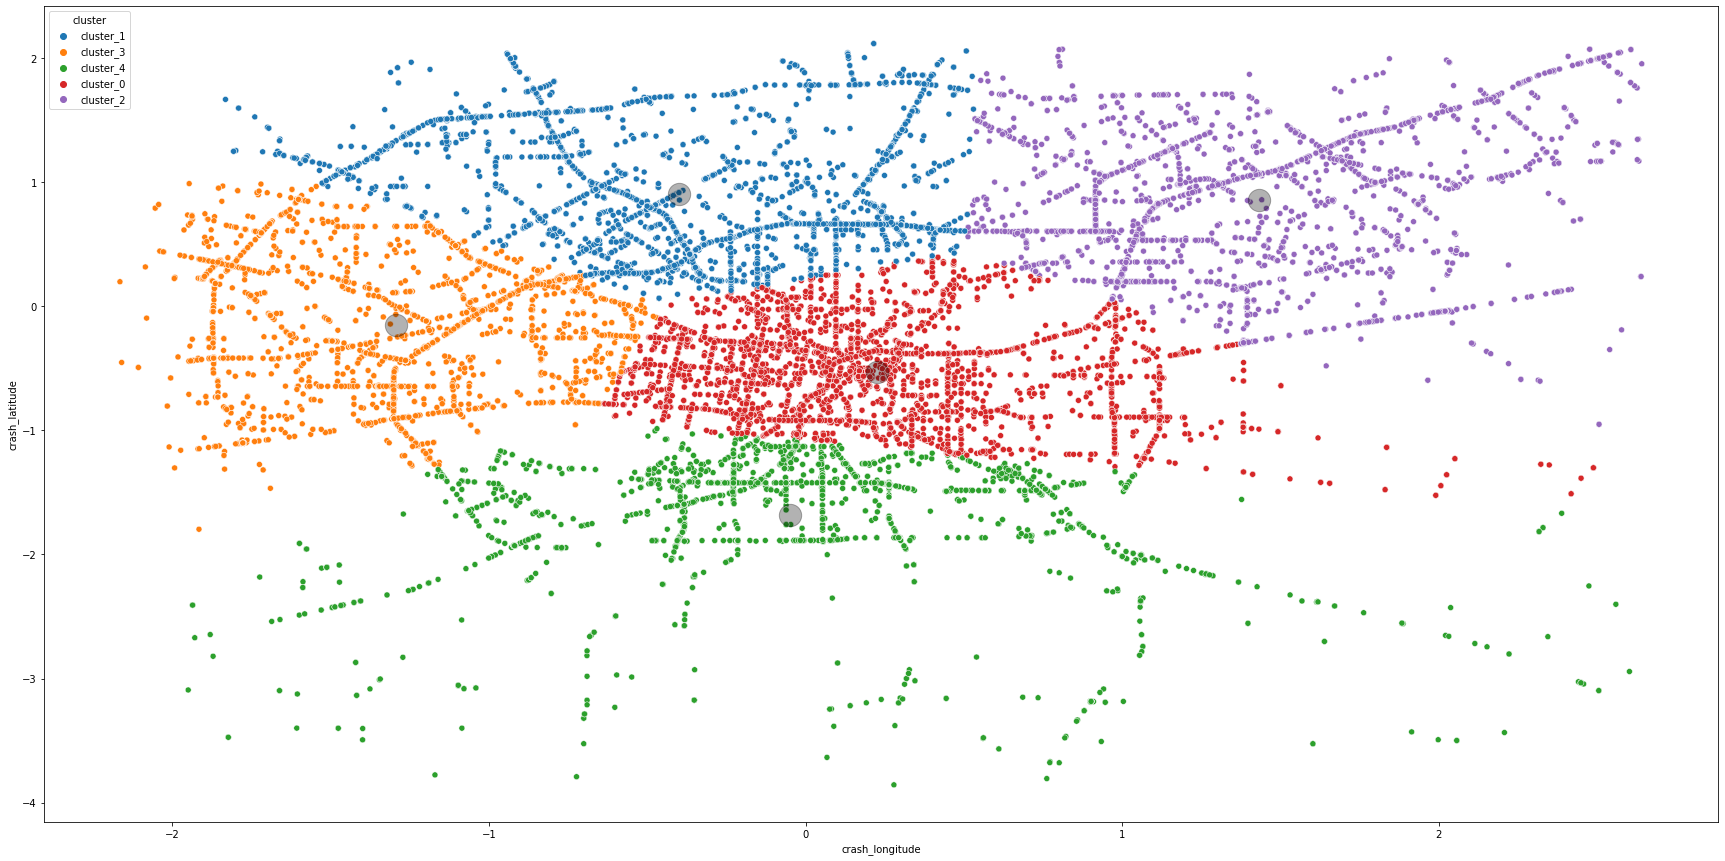

In [8]:
X = train_scaled[['crash_longitude', 'crash_latitude']]
train_scaled, kmeans, centroids = ae.create_cluster(train_scaled, X, 5)
ae.create_scatter_plot('crash_longitude','crash_latitude',train_scaled,kmeans, X)
print('Clusters based on longitude and latitude')

In [9]:
#add location clusters under cluster
train['cluster'] = kmeans.predict(X)

In [10]:
X = test_scaled[['crash_longitude', 'crash_latitude']]
test_scaled, kmeans, centroids = ae.create_cluster(test_scaled, X, 5)

test['cluster'] = kmeans.predict(X)

In [11]:
train.shape, test.shape

((22284, 47), (5572, 47))

Does the damage zone and speed limit have an effect on injuries reported? 

In [12]:
train, test = ae.create_kmode_clusters(train, test, 5, cluster_name= 'damage_speed_lm', var=['damage_zone','factors_spd_lmt_mph'])

Does the type of vehicle, where it is damaged, and the speed limit have an effect on injuries reported?

In [13]:
train, test = ae.create_kmode_clusters(train, test, 5, cluster_name= 'vehicle_damage_speed_lm', var=['vehicle_type','damage_zone','factors_spd_lmt_mph'])

Does being at fault for speeding and being at fault for failure to yield have an effect on injuries reported?

In [14]:
train, test = ae.create_kmode_clusters(train, test, 4, cluster_name= 'speed_yield', var=['fault_speed','fault_yield'])

Does where the car is hit and if airbags were deployed affect if injuries are reported? (Ended up using this one)

In [15]:
train, test = ae.create_kmode_clusters(train, test, 4, cluster_name= 'damage_air', var=['damage_zone','damage_airbag'])

Does being at fault for speeding and the speed limit have an effect if injuries are reported? (ended up using this one)

In [16]:
train, test = ae.create_kmode_clusters(train, test, 4, cluster_name= 'speed_speed_lm', var=['fault_speed','factors_spd_lmt_mph'])

Does vehicle type and whether the airbags deploy have an effect if injuries are reported?

In [17]:
train, test = ae.create_kmode_clusters(train, test, 4, cluster_name= 'damage_air', var=['vehicle_type','damage_airbag'])

Cluster Takaways:
    - location is not very significant to how injuries are reported.
    - where the car is damaged is significant to whether an injury is reported or not, especially combined with speed limit, and vehicle type
    - speed limit is significant, clusters using speed limit tend to be significant to injuries reported
    - air bag deployment 

In [18]:
#ae.elbow_kmode(train, n=20, var=['crash_hour','crash_day_of_week'])

In [19]:
#train, test = ae.create_kmode_clusters(train, test, 6, cluster_name= 'hour_day', var=['crash_hour','crash_day_of_week'])

In [20]:
#ae.chi2(train.hour_day, train.injury_class, alpha=0.05)

#was not significant

In [21]:
train.columns

Index(['crash_date', 'crash_id', 'crash_latitude', 'crash_longitude',
       'crash_occupant_count', 'crash_vehicle_count', 'damage_airbag',
       'damage_burned', 'damage_concentrated', 'damage_distributed',
       'damage_rollover', 'damage_zone', 'dl_cdl', 'dl_class_a', 'dl_class_b',
       'dl_class_m', 'dl_state', 'dl_unlicensed', 'driver_age', 'driver_male',
       'driver_race', 'factors_road', 'factors_spd_lmt_mph', 'factors_weather',
       'fault_class', 'fault_distraction', 'fault_fatigue',
       'fault_intoxication', 'fault_maneuver', 'fault_narrative',
       'fault_speed', 'fault_yield', 'injury_class', 'injury_crash_total',
       'vehicle_color', 'vehicle_id', 'vehicle_make', 'vehicle_occupant_count',
       'vehicle_type', 'vehicle_year', 'crash_time', 'crash_hour',
       'crash_day_of_week', 'accident_contained_injury', 'vehicle_type_num',
       'week_num', 'cluster', 'damage_speed_lm', 'vehicle_damage_speed_lm',
       'speed_yield', 'damage_air', 'speed_speed_lm

In [22]:
train.dtypes

crash_date                   datetime64[ns]
crash_id                              int64
crash_latitude                      float64
crash_longitude                     float64
crash_occupant_count                  int64
crash_vehicle_count                   int64
damage_airbag                         int64
damage_burned                         int64
damage_concentrated                   int64
damage_distributed                    int64
damage_rollover                       int64
damage_zone                           int64
dl_cdl                                int64
dl_class_a                            int64
dl_class_b                            int64
dl_class_m                            int64
dl_state                             object
dl_unlicensed                         int64
driver_age                            int64
driver_male                           int64
driver_race                          object
factors_road                         object
factors_spd_lmt_mph             

In [23]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

def get_numeric_X_cols(X_train, object_cols):
    '''
    takes in a dataframe and list of object column names
    and returns a list of all other columns names, the non-objects. 
    '''
    numeric_cols = [col for col in X_train.columns.values if col not in object_cols]
    
    return numeric_cols

In [24]:
X_train, y_train, X_test, y_test = ap.split_X_y(train, test, 'injury_class')

In [25]:
obj_cols = get_object_cols(train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [38]:
num_cols

['crash_id',
 'crash_latitude',
 'crash_longitude',
 'crash_occupant_count',
 'crash_vehicle_count',
 'damage_airbag',
 'damage_burned',
 'damage_concentrated',
 'damage_distributed',
 'damage_rollover',
 'damage_zone',
 'dl_cdl',
 'dl_class_a',
 'dl_class_b',
 'dl_class_m',
 'dl_unlicensed',
 'driver_age',
 'driver_male',
 'factors_spd_lmt_mph',
 'fault_class',
 'fault_distraction',
 'fault_fatigue',
 'fault_intoxication',
 'fault_maneuver',
 'fault_speed',
 'fault_yield',
 'injury_crash_total',
 'vehicle_occupant_count',
 'vehicle_year',
 'crash_hour',
 'accident_contained_injury',
 'vehicle_type_num',
 'week_num',
 'cluster',
 'damage_speed_lm',
 'vehicle_damage_speed_lm',
 'speed_yield',
 'damage_air',
 'speed_speed_lm']

In [40]:
num_cols.remove('crash_date')
num_cols.remove('driver_age')
num_cols.remove('driver_male')
num_cols.remove('accident_contained_injury')
num_cols.remove('injury_crash_total')

In [43]:
num_cols.remove('crash_id')

In [27]:
def select_kbest(X,y,top):
    f_selector = SelectKBest(f_regression, top)
    f_selector.fit(X,y)
    result = f_selector.get_support()
    f_feature = X.loc[:,result].columns.tolist()
    return f_feature

def select_rfe(X, y, n, alg):
    alg = alg
    rfe = RFE(alg, n)
    X_rfe = rfe.fit_transform(X,y)
    mask = rfe.support_
    rfe_feautures = X.loc[:,mask].columns.tolist()
    return rfe_feautures

In [41]:
select_kbest(X_train[num_cols],y_train,15)

['crash_occupant_count',
 'damage_airbag',
 'damage_distributed',
 'damage_rollover',
 'dl_cdl',
 'dl_class_a',
 'dl_class_b',
 'factors_spd_lmt_mph',
 'fault_class',
 'fault_speed',
 'vehicle_occupant_count',
 'vehicle_type_num',
 'speed_yield',
 'damage_air',
 'speed_speed_lm']

In [45]:
alg = LogisticRegression()
select_rfe(X_train[num_cols], y_train, 15, alg)

['crash_latitude',
 'damage_airbag',
 'damage_distributed',
 'damage_rollover',
 'dl_cdl',
 'dl_class_a',
 'dl_class_b',
 'dl_class_m',
 'fault_class',
 'fault_fatigue',
 'fault_speed',
 'fault_yield',
 'vehicle_occupant_count',
 'vehicle_type_num',
 'speed_speed_lm']

In [46]:
alg = DecisionTreeClassifier()
select_rfe(X_train[num_cols], y_train, 15, alg)

['crash_latitude',
 'crash_longitude',
 'crash_occupant_count',
 'crash_vehicle_count',
 'damage_airbag',
 'damage_zone',
 'factors_spd_lmt_mph',
 'vehicle_occupant_count',
 'vehicle_year',
 'crash_hour',
 'vehicle_type_num',
 'week_num',
 'damage_speed_lm',
 'vehicle_damage_speed_lm',
 'speed_speed_lm']

In [48]:
alg = RandomForestClassifier()
select_rfe(X_train[num_cols], y_train, 15, alg)

['crash_latitude',
 'crash_longitude',
 'crash_occupant_count',
 'crash_vehicle_count',
 'damage_airbag',
 'damage_zone',
 'factors_spd_lmt_mph',
 'vehicle_occupant_count',
 'vehicle_year',
 'crash_hour',
 'vehicle_type_num',
 'week_num',
 'cluster',
 'damage_speed_lm',
 'vehicle_damage_speed_lm']

In [74]:
X = ['crash_occupant_count',
 'damage_airbag',
 'damage_distributed',
 'damage_rollover',
 'dl_cdl',
 'dl_class_a',
 'dl_class_b',
 'factors_spd_lmt_mph',
 'fault_class',
 'fault_speed',
 'vehicle_occupant_count',
 'vehicle_type_num',
 'speed_yield',
 'damage_air',
 'speed_speed_lm']

In [75]:
train['baseline_prediction'] = 0

baseline_score = round(accuracy_score(train.injury_class, train.baseline_prediction),5)
print(f'Our baseline score is {baseline_score}')

Our baseline score is 0.84042


### Decision Tree

In [76]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

tree = DecisionTreeClassifier()

grid = GridSearchCV(tree, params, cv=3)

grid.fit(X_train[X], y_train)

results = grid.cv_results_

test_scores = results['mean_test_score']

params = results['params']

for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

,max_depth,max_features,score
6,4,NaN,0.840109
3,3,NaN,0.840244
7,4,1.0,0.840244
5,3,3.0,0.840289
8,4,3.0,0.840334
0,2,NaN,0.840424
1,2,1.0,0.840424
4,3,1.0,0.840424
2,2,3.0,0.840603


In [90]:
tree = DecisionTreeClassifier(max_depth=3, max_features=1)
tree.fit(X_train[X],y_train)
y_pred = tree.predict(X_train[X])

cross_val_score(tree, X_train[X], y_train, cv=3)

array([0.8404685 , 0.84019925, 0.84033387])

### KNN

In [78]:
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, params, cv=3)

grid.fit(X_train[X], y_train)

results = grid.cv_results_

test_scores = results['mean_test_score']

params = results['params']

for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

,n_neighbors,score
1,3,0.807171
3,5,0.825974
0,2,0.828846
2,4,0.832526
5,7,0.832660
7,9,0.835846
4,6,0.836654
8,10,0.838853
6,8,0.839795


In [92]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train[X],y_train)
y_pred = knn.predict(X_train[X])

cross_val_score(knn, X_train[X], y_train, cv=3)

array([0.84006462, 0.83966074, 0.8368336 ])

### Logistic Regression

In [80]:
params = {'C': [0.2, 0.5, 1, 1.2, 1.5, 2]}

logit = LogisticRegression()

grid = GridSearchCV(logit, params, cv=3)

grid.fit(X_train[X], y_train)

results = grid.cv_results_

test_scores = results['mean_test_score']

params = results['params']

for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

,C,score
5,2.0,0.840693
0,0.2,0.840962
2,1.0,0.840962
4,1.5,0.841007
3,1.2,0.841366
1,0.5,0.841635


In [94]:
logit = LogisticRegression(C=0.5)
logit.fit(X_train[X],y_train)
y_pred = logit.predict(X_train[X])

cross_val_score(logit, X_train[X], y_train, cv=3)

array([0.841007  , 0.84181475, 0.84208401])

In [85]:
def get_metrics(clf):
    '''
    get_metrics takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    X_train, y_train = train[x_col], train[y_col]

    #X_validate, y_validate = validate[x_col], validate[y_col]

    X_test, y_test = test[x_col], test[y_col]
    
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [86]:
#our selected features
x_col = X
y_col='injury_class'

In [91]:
get_metrics(tree)


    The accuracy for our model is 0.8404
    The True Positive Rate is 0.0, The False Positive Rate is 0.0,
    The True Negative Rate is 1.0, and the False Negative Rate is 1.0
    


,precision,recall,f1-score,support
0,0.840424,1.000000,0.913294,18728.000000
1,0.000000,0.000000,0.000000,3556.000000
accuracy,0.840424,0.840424,0.840424,0.840424
macro avg,0.420212,0.500000,0.456647,22284.000000
weighted avg,0.706312,0.840424,0.767554,22284.000000


In [93]:
get_metrics(knn)


    The accuracy for our model is 0.8447
    The True Positive Rate is 0.0588, The False Positive Rate is 0.00603,
    The True Negative Rate is 0.994, and the False Negative Rate is 0.941
    


,precision,recall,f1-score,support
0,0.847600,0.993966,0.914967,18728.000000
1,0.649068,0.058774,0.107788,3556.000000
accuracy,0.844732,0.844732,0.844732,0.844732
macro avg,0.748334,0.526370,0.511377,22284.000000
weighted avg,0.815919,0.844732,0.786160,22284.000000


In [95]:
get_metrics(logit)


    The accuracy for our model is 0.8417
    The True Positive Rate is 0.0526, The False Positive Rate is 0.00844,
    The True Negative Rate is 0.992, and the False Negative Rate is 0.947
    


,precision,recall,f1-score,support
0,0.846438,0.991563,0.913271,18728.000000
1,0.542029,0.052587,0.095873,3556.000000
accuracy,0.841725,0.841725,0.841725,0.841725
macro avg,0.694233,0.522075,0.504572,22284.000000
weighted avg,0.797861,0.841725,0.782834,22284.000000


In [97]:
from imblearn.datasets import make_imbalance

In [98]:
from imblearn.over_sampling import SMOTE

In [100]:
sm = SMOTE(random_state = 19)

In [105]:
X_train_res, y_train_res = sm.fit_resample(X_train[num_cols], y_train)

In [106]:
X_train_res.shape, y_train_res.shape

((37456, 34), (37456,))

In [ ]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

tree = DecisionTreeClassifier()

grid = GridSearchCV(tree, params, cv=3)

grid.fit(X_train[X], y_train)

results = grid.cv_results_

test_scores = results['mean_test_score']

params = results['params']

for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

In [139]:
def grid_search(model, X_train, y_train):
    if model == 'LogisticRegression':
        logit = LogisticRegression()
        params = {'C': [0.2, 0.5, 1, 1.2, 1.5, 2]}
        grid = GridSearchCV(logit, params, cv=3, scoring='recall')
        grid.fit(X_train, y_train)
        results = grid.cv_results_
        test_scores = results['mean_test_score']
        params = results['params']
        for p, s in zip(params, test_scores):
            p['score'] = s
        print(pd.DataFrame(params).sort_values(by='score'))
        print(cross_val_score(logit, X_train[X], y_train, cv=3))
        
    elif model == 'DecisionTree':
        tree = DecisionTreeClassifier()
        params = {'max_depth': [2, 3, 4, 5],
          'max_features': [None, 1, 2, 3, 4]}
        grid = GridSearchCV(tree, params, cv=3, scoring='recall')
        grid.fit(X_train, y_train)
        results = grid.cv_results_
        test_scores = results['mean_test_score']
        params = results['params']
        for p, s in zip(params, test_scores):
            p['score'] = s
        print(pd.DataFrame(params).sort_values(by='score'))
        
        
    elif model == 'KNN':
        knn = KNeighborsClassifier()
        params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
        grid = GridSearchCV(knn, params, cv=3, scoring='recall')
        grid.fit(X_train, y_train)
        results = grid.cv_results_
        test_scores = results['mean_test_score']
        params = results['params']
        for p, s in zip(params, test_scores):
            p['score'] = s
        print(pd.DataFrame(params).sort_values(by='score'))    
        
    elif model == 'RandomForest':
        rf = RandomForestClassifier()
        params = {'min_samples_leaf': [1,2,3],
                 'n_estimators': [50, 100, 150],
                 'max_depth': [1,2,3,4,5,6,7,8,9,10]}
        grid = GridSearchCV(rf, params, cv=3, scoring='recall')
        grid.fit(X_train, y_train)
        results = grid.cv_results_
        test_scores = results['mean_test_score']
        params = results['params']
        for p, s in zip(params, test_scores):
            p['score'] = s
        print(pd.DataFrame(params).sort_values(by='score'))
        

In [140]:
grid_search('KNN', X_train[X], y_train)

   n_neighbors     score
8           10  0.031779
6            8  0.036838
4            6  0.045557
2            4  0.046964
7            9  0.055402
0            2  0.063553
5            7  0.072838
3            5  0.087175
1            3  0.138640
